In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot

The number of lines in each file match, indicating that one row is one record in each data file.

We trasnfrom the data in [samples, timesteps, features] format for analysis of deep learning models

In [2]:
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    #return as numpy array
    return dataframe.values

#[samples, timesteps, features]
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group for features 
    loaded = np.dstack(loaded)
    return loaded

# For loading train & test group
def load_dataset(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y
 


In [3]:
# load all train
trainX, trainy = load_dataset('train', 'UCI HAR Dataset/')
print(trainX.shape, trainy.shape)
# load all test
testX, testy = load_dataset('test', 'UCI HAR Dataset/')
print(testX.shape, testy.shape)

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)


From this, we can know that the training data consits of 7352 rows / windows of data, and each window has 128 observations, captured in chronological order and 9 features. The size of windows in train and test set matches

# Check Class Distribution in Train and Test

In [4]:
def count_distribution(data):
    #convert back to dataframe
    df=pd.DataFrame(data)
    counts=df.groupby(0).size()
    counts=counts.values
    for i in range(len(counts)):
        percent = counts[i] / len(df) * 100
        print('Class=%d, total=%d, percentage=%.3f' % (i+1, counts[i], percent))

In [5]:
# Load train file
#trainy = load_file('UCI HAR Dataset/train/y_train.txt')
print('Train Dataset')
count_distribution(trainy)
# load test file
#testy = load_file('UCI HAR Dataset/test/y_test.txt')
# summarize class breakdown
print('Test Dataset')
count_distribution(testy)

Train Dataset
Class=1, total=1226, percentage=16.676
Class=2, total=1073, percentage=14.595
Class=3, total=986, percentage=13.411
Class=4, total=1286, percentage=17.492
Class=5, total=1374, percentage=18.689
Class=6, total=1407, percentage=19.138
Test Dataset
Class=1, total=496, percentage=16.831
Class=2, total=471, percentage=15.982
Class=3, total=420, percentage=14.252
Class=4, total=491, percentage=16.661
Class=5, total=532, percentage=18.052
Class=6, total=537, percentage=18.222


The distribution of class in both train and test is consider even. Accuracy can be used as metric to evaluate the performance of the model

# Plot time series

The sensor signals (accelerometer and gyroscope) were pre-processed by applying noise filters and then sampled in fixed-width sliding windows of 2.56 sec and 50% overlap (128 readings/window). Hence, the data should remove the overlap part and put it in a long sequence for plotting

In [6]:
# get all data for one subject
def data_for_subject(X, y, sub_map, sub_id):
    ix = [i for i in range(len(sub_map)) if sub_map[i]==sub_id]
    return X[ix, :, :], y[ix]
 
# convert a series of windows to a 1D list
def to_series(windows):
    series = list()
    for window in windows:
        # remove the overlap from the window
        half = int(len(window) / 2) - 1
        for value in window[-half:]:
            series.append(value)
    return series
 

def plot_subject(X, y):
    pyplot.figure()

    n, off = X.shape[2] + 1, 0
    # plot total acc
    for i in range(3):
        pyplot.subplot(n, 1, off+1)
        pyplot.plot(to_series(X[:, :, off]))
        pyplot.title('total acc '+str(i), y=0, loc='left')
        off += 1
    # plot body acc
    for i in range(3):
        pyplot.subplot(n, 1, off+1)
        pyplot.plot(to_series(X[:, :, off]))
        pyplot.title('body acc '+str(i), y=0, loc='left')
        off += 1
    # plot body gyro
    for i in range(3):
        pyplot.subplot(n, 1, off+1)
        pyplot.plot(to_series(X[:, :, off]))
        pyplot.title('body gyro '+str(i), y=0, loc='left')
        off += 1
    # plot activities
    pyplot.subplot(n, 1, n)
    pyplot.plot(y)
    pyplot.title('activity', y=0, loc='left')
    pyplot.show()

From the ReadMe file, we can know that the "subject_train.txt" file contains mapping of each line in the data files with their subject identifier

[ 1  3  5  6  7  8 11 14 15 16 17 19 21 22 23 25 26 27 28 29 30]
(347, 128, 9) (347, 1)


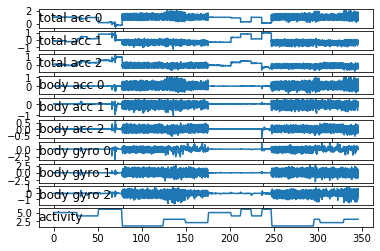

In [7]:
# sub_map provides mapping of rows to subject
sub_map = load_file('UCI HAR Dataset/train/subject_train.txt')
train_subjects = np.unique(sub_map)
print(train_subjects)

# get the data for one subject
sub_id = train_subjects[0]
subX, suby = data_for_subject(trainX, trainy, sub_map, sub_id)
print(subX.shape, suby.shape)

# plot data for subject
plot_subject(subX, suby)

From the plot, we can see that windows with large movement corresponding to activity 1,2,3 (Walking). Less activity correspond to activity 4,5,6 (sitting,standing,laying) which with less movement

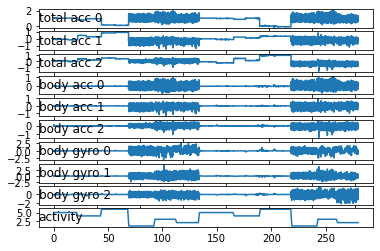

In [8]:
sub_id = train_subjects[5]
subX, suby = data_for_subject(trainX, trainy, sub_map, sub_id)
plot_subject(subX, suby)

The plot for the other subject prove the conclusion that draw from first plot is correct, which means we can draw predict human activity through the data collected from the accelerometer

# Histogram

The plot_subject_histograms() function below takes the loaded dataset and mapping of rows to subjects as well as a maximum number of subjects to plot, fixed at 10 by default.

In [9]:
# plot histograms for multiple subjects,default 10 subjects
def plot_subject_total_acc_histograms(X, y, sub_map, n=10):
    pyplot.figure()

    # get unique subjects
    subject_ids = np.unique(sub_map[:,0])

    xaxis = None
    for k in range(n):
        sub_id = subject_ids[k]
        # get data for one subject
        subX, _ = data_for_subject(X, y, sub_map, sub_id)
        # acc
        direc=['X','Y','Z']
        for i in range(3):
            ax = pyplot.subplot(n, 1, k+1, sharex=xaxis)
            ax.set_xlim(-1,1)
            if k == 0:
                xaxis = ax
            # total acc
            pyplot.hist(to_series(subX[:,:,i]), bins=100,label=direc[i])
            # body acc
            #pyplot.hist(to_series(subX[:,:,i]), bins=100,label=direc[i])
            # gyro acc
            #pyplot.hist(to_series(subX[:,:,i]), bins=100,label=direc[i])
    pyplot.legend(loc='best')
    pyplot.show()

C:\Users\wongy\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


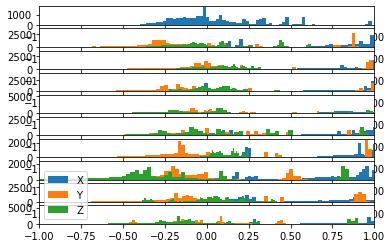

In [10]:
# trainX,trainy contains
plot_subject_total_acc_histograms(trainX, trainy, sub_map)

We can see that there is continuity of data, this histogram should be compared to the activity plot above

In [11]:
# plot histograms for multiple subjects,default 10 subjects
def plot_subject_body_acc_histograms(X, y, sub_map, n=10):
    pyplot.figure()

    # get unique subjects
    subject_ids = np.unique(sub_map[:,0])

    xaxis = None
    for k in range(n):
        sub_id = subject_ids[k]
        # get data for one subject
        subX, _ = data_for_subject(X, y, sub_map, sub_id)
        # acc
        direc=['X','Y','Z']
        for i in range(3):
            ax = pyplot.subplot(n, 1, k+1, sharex=xaxis)
            ax.set_xlim(-1,1)
            if k == 0:
                xaxis = ax
            # total acc
            #pyplot.hist(to_series(subX[:,:,i]), bins=100,label=direc[i])
            # body acc
            pyplot.hist(to_series(subX[:,:,i+3]), bins=100,label=direc[i])
            # gyro acc
            #pyplot.hist(to_series(subX[:,:,i]), bins=100,label=direc[i])
    pyplot.legend(loc='best')
    pyplot.show()

C:\Users\wongy\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


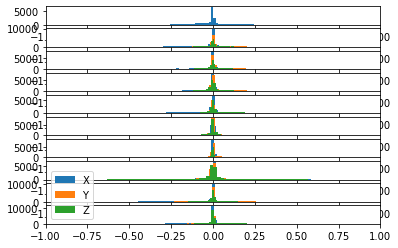

In [12]:
plot_subject_body_acc_histograms(trainX, trainy, sub_map)

Differences accross subject in total acceleration may not helpful.

Gyro acc

In [13]:
# plot histograms for multiple subjects,default 10 subjects
def plot_subject_gyro_acc_histograms(X, y, sub_map, n=10):
    pyplot.figure()

    # get unique subjects
    subject_ids = np.unique(sub_map[:,0])

    xaxis = None
    for k in range(n):
        sub_id = subject_ids[k]
        # get data for one subject
        subX, _ = data_for_subject(X, y, sub_map, sub_id)
        # acc
        direc=['X','Y','Z']
        for i in range(3):
            ax = pyplot.subplot(n, 1, k+1, sharex=xaxis)
            ax.set_xlim(-1,1)
            if k == 0:
                xaxis = ax
            # total acc
            #pyplot.hist(to_series(subX[:,:,i]), bins=100,label=direc[i])
            # body acc
            #pyplot.hist(to_series(subX[:,:,i]), bins=100,label=direc[i])
            # gyro acc
            pyplot.hist(to_series(subX[:,:,i+6]), bins=100,label=direc[i])
    pyplot.legend(loc='best')
    pyplot.show()

C:\Users\wongy\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


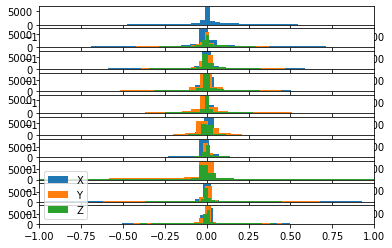

In [14]:
plot_subject_gyro_acc_histograms(trainX, trainy, sub_map)

From the histograms, we can see that the data is likely in Gaussian Distribution for each subject centered on 0.0. This let us have an understanding on modelling movement data across subjects

# Histogram for activity

In [15]:
# For changing subject id
sub_id = train_subjects[0]
subX, suby = data_for_subject(trainX, trainy, sub_map, sub_id)

In [16]:
# group data by activity
def data_by_activity(X, y, activities):
    return {a:X[y[:,0]==a, :, :] for a in activities}
 
# plot histograms for each activity for a subject
def total_acc_plot_activity_histograms(X, y):
    activity_ids = np.unique(y[:,0])
    grouped = data_by_activity(X, y, activity_ids)
    pyplot.figure()
    xaxis = None
    activity_name=['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING']
    for k in range(len(activity_ids)):
        act_id = activity_ids[k]
        
        for i in range(3):
            ax = pyplot.subplot(len(activity_ids), 1, k+1, sharex=xaxis)
            ax.set_xlim(-1,1)
            if k == 0:
                xaxis = ax
            # total acceleration
            pyplot.hist(to_series(grouped[act_id][:,:,i]), bins=100)
            # body acceleration
            #pyplot.hist(to_series(grouped[act_id][:,:,i+3]), bins=100)
            # gyro acceleration
            #pyplot.hist(to_series(grouped[act_id][:,:,i+6]), bins=100)
            title=activity_name[act_id-1]
            pyplot.title(title, y=0, loc='left')
    pyplot.show()

C:\Users\wongy\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


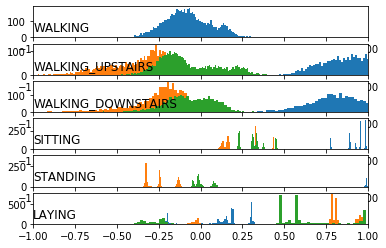

In [17]:
total_acc_plot_activity_histograms(subX,suby)

There is big difference between the first three activity and last three activity

In [18]:
# plot histograms for each activity for a subject
def body_acc_plot_activity_histograms(X, y):
    activity_ids = np.unique(y[:,0])
    grouped = data_by_activity(X, y, activity_ids)
    pyplot.figure()
    xaxis = None
    activity_name=['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING']
    for k in range(len(activity_ids)):
        act_id = activity_ids[k]
        
        for i in range(3):
            ax = pyplot.subplot(len(activity_ids), 1, k+1, sharex=xaxis)
            ax.set_xlim(-1,1)
            if k == 0:
                xaxis = ax
            # total acceleration
            #pyplot.hist(to_series(grouped[act_id][:,:,i]), bins=100)
            # body acceleration
            pyplot.hist(to_series(grouped[act_id][:,:,i+3]), bins=100)
            # gyro acceleration
            #pyplot.hist(to_series(grouped[act_id][:,:,i+6]), bins=100)
            title=activity_name[act_id-1]
            pyplot.title(title, y=0, loc='left')
    pyplot.show()

In [19]:
# plot histograms for each activity for a subject
def gyro_acc_plot_activity_histograms(X, y):
    activity_ids = np.unique(y[:,0])
    grouped = data_by_activity(X, y, activity_ids)
    pyplot.figure()
    xaxis = None
    activity_name=['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING']
    for k in range(len(activity_ids)):
        act_id = activity_ids[k]
        
        for i in range(3):
            ax = pyplot.subplot(len(activity_ids), 1, k+1, sharex=xaxis)
            ax.set_xlim(-1,1)
            if k == 0:
                xaxis = ax
            # total acceleration
            #pyplot.hist(to_series(grouped[act_id][:,:,i]), bins=100)
            # body acceleration
            #pyplot.hist(to_series(grouped[act_id][:,:,i+3]), bins=100)
            # gyro acceleration
            pyplot.hist(to_series(grouped[act_id][:,:,i+6]), bins=100)
            title=activity_name[act_id-1]
            pyplot.title(title, y=0, loc='left')
    pyplot.show()

C:\Users\wongy\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


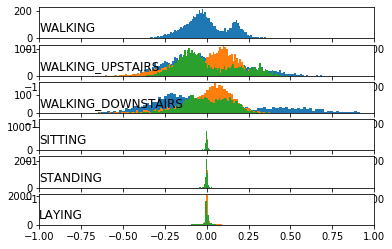

In [20]:
body_acc_plot_activity_histograms(subX,suby)

C:\Users\wongy\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


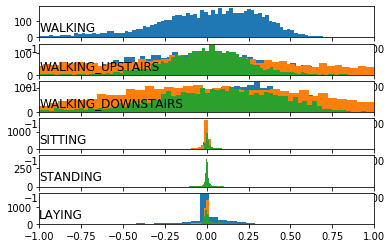

In [21]:
gyro_acc_plot_activity_histograms(subX,suby)

These three histograms supports conclusion of there is big difference between the first three activity and last three activity.
This three histograms is plotted according to train_subjects[0], other subject is expected to have similar distribution

# Duration Boxplot

Purpose of doing this is to see whethere there is a need to reduce the windows size 

In [22]:
# group data by activity
def data_by_activity(X, y, activities):
    return {a:X[y[:,0]==a, :, :] for a in activities}
 
# plot activity durations by subject
def plot_activity_durations_by_subject(X, y, sub_map):
    # get unique subjects and activities
    subject_ids = np.unique(sub_map[:,0])
    activity_ids = np.unique(y[:,0])
    activity_windows = {a:list() for a in activity_ids}
    
    for sub_id in subject_ids:
        _, subj_y = data_for_subject(X, y, sub_map, sub_id)
        for a in activity_ids:
            activity_windows[a].append(len(subj_y[subj_y[:,0]==a]))
    # organize durations into a list of lists
    durations = [activity_windows[a] for a in activity_ids]
    pyplot.boxplot(durations, labels=activity_ids)
    pyplot.show()

In [23]:
# load all train
trainX, trainy = load_dataset('train', 'UCI HAR Dataset/')
sub_map = load_file('UCI HAR Dataset/train/subject_train.txt')

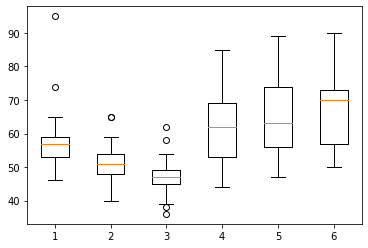

In [24]:
plot_activity_durations_by_subject(trainX,trainy,sub_map)

This shows that it is only little need to trim the long duration activities

In [25]:
# load all test
testX, testy = load_dataset('test', 'UCI HAR Dataset/')
sub_map = load_file('UCI HAR Dataset/test/subject_test.txt')

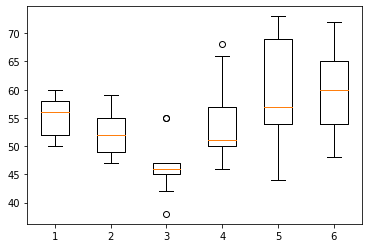

In [26]:
plot_activity_durations_by_subject(testX, testy,sub_map)

Test set is basically similar to train set

Other than Inertial Signals, we will use X_train for modelling